# Using the Group Stretch proposal

In this tutorial, we will use the Group Stretch proposal in a simple example. The Group Stretch is very useful when our nested model is ... 

### 0. Necessary imports

In [1]:
import numpy as np
from chainconsumer import ChainConsumer
import matplotlib.pyplot as plt
import matplotlib as mpl
def update_mpl(mpl):
    rcparams = {}
    rcparams["axes.linewidth"] = 0.5
    rcparams["font.family"] = "serif"
    rcparams["font.size"] = 18
    rcparams["legend.fontsize"] = 14
    rcparams["mathtext.fontset"] = "stix"
    mpl.rcParams.update(rcparams) # update plot parameters
    useserif=True
    plottempsetc=False
    mpl.rcParams["text.usetex"]=True
    return mpl
mpl = update_mpl(mpl)
from matplotlib import cm

from eryn.state import State
from eryn.ensemble import EnsembleSampler
from eryn.prior import uniform_dist
from eryn.moves import GaussianMove, GroupStretchMove, StretchMove, CombineMove
from eryn.backends import HDFBackend

Define the setup of the simulation. Choose the number of pulses to inject in the data (any between 1 and 30 should work fine for this example), the number of MCMC steps, and the number of temperatures and walkers.

In [2]:
nsteps = 2000  # total mcmc steps
burnin = 1000  # burn in period steps
ntemps = 5     # number of temperatures
nwalkers = 20  # mumber of walkers
npulses = 10   # number of pulses to inject

np.random.seed(123456) # Set the random seed

### 1. Generate the data-set

In [3]:
# Set number of samples and the x-axis vector
num     = 100
lowlim  = - 0.1 * num # put all injections well inside the measurement (avoid edges)
highlim = 0.1 * num
dt      = (highlim - lowlim)/num 
x, y    = np.mgrid[lowlim:highlim:dt, lowlim:highlim:dt]
Amp     = np.random.uniform(.8, 1.2, size=(npulses))
spread  = .2
sigma   = spread * np.diag(np.ones(2))
edges   = 2

# Set the injection parameters
inj_coordinates = np.random.uniform(lowlim+edges, highlim-edges, size=(npulses, 2))

gauss_inj_params = [ [AA, xy[0], xy[1]] for AA, xy in zip(Amp, inj_coordinates)]

print(" * Parameters injected: \n\n", np.matrix(gauss_inj_params), "\n\n")

sigma_det = np.linalg.det(sigma)
sigma_inv = np.linalg.inv(sigma)
norm      = np.sqrt((2*np.pi)**2 * sigma_det)

sgm1, sgm2 = sigma[0,0], sigma[1,1]

def gaussian_flat(x, y, a, b, c):
    """
        Gaussian (2D) flat. Yields the flattened vector of 
        distributions for given parameters input:
        x, y - The coordinates
        a, b, c, the amplitude, and the position of each pulse.
    """
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y
    mu = [b, c]
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a 
    # vectorized way across all the input variables.
    fac = np.einsum("...k,kl,...l->...", pos-mu, sigma_inv, pos-mu)
    return a * np.exp(- fac / 2) / norm

sigma_noise = [[0.2]]
noise = sigma_noise[0][0] * np.random.randn( num, num )

# Generate the data-set
injection = np.zeros( (num, num) )
for params in gauss_inj_params:
    injection += gaussian_flat(x, y, *params)
data = injection + noise

params = np.array(gauss_inj_params)
params[:,0] = params[:,0]

 * Parameters injected: 

 [[ 0.85078793 -2.0318044  -0.83205081]
 [ 1.18668714 -5.92894912  5.75805931]
 [ 0.9041904   5.12621381 -2.36714337]
 [ 1.15889461 -4.33780313  4.42854001]
 [ 0.95069989  1.51653743 -5.79914309]
 [ 0.9344887   5.6463965  -4.23188034]
 [ 0.98055059 -5.66036428  1.43790037]
 [ 1.13610203  1.1841884  -7.0196806 ]
 [ 0.84924086  1.44681605 -4.07440289]
 [ 1.01721048 -2.552881    7.75565983]] 




Make a plot of the generated data:

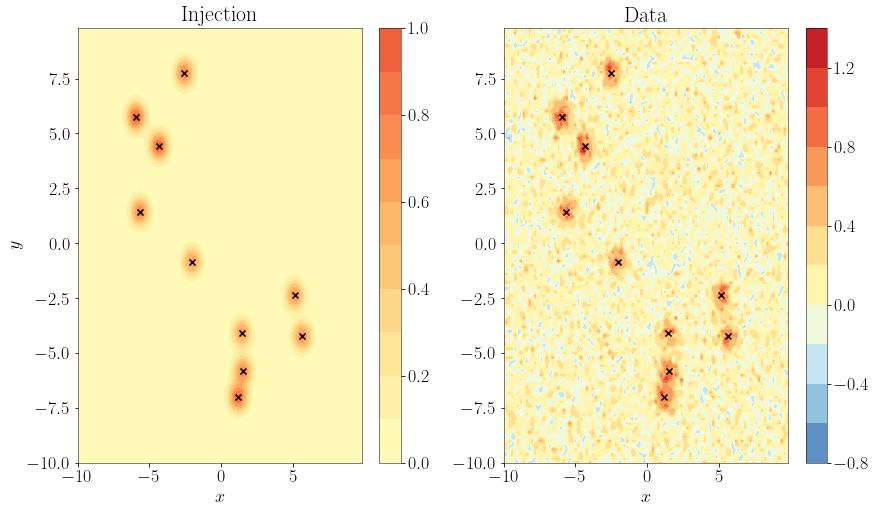

In [21]:
import matplotlib.colors as colors
vmin = - 1.0 
vmax = 1.5
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig = plt.figure(figsize=(14,8))
plt.subplot(121)
cf = plt.contourf(x, y, injection, 10, norm=norm, cmap=cm.RdYlBu_r)
plt.scatter(params[:,1], params[:,2], marker="x", color="k")
plt.colorbar(cf)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.subplot(122)
cf = plt.contourf(x, y, data, 10, norm=norm, cmap=cm.RdYlBu_r)
plt.scatter(params[:,1], params[:,2], marker="x", color="k")
plt.xlabel(r"$x$")
plt.colorbar(cf)
ax_list = fig.axes
ax_list[0].title.set_text("Injection")
ax_list[2].title.set_text("Data")
plt.show()

### 2. Define the necessary functions

In [5]:
def gaussian(X, Y, a, b, c):
    x = X[:,0]
    y = Y[0,:]
    A = np.exp(-((x[:, None] - b) ** 2) / (2 * sgm1))
    B = np.exp(-((y[:, None] - c) ** 2) / (2 * sgm2)) 
    C =  A*B[:,None,:] # (np.enpand_dims(A,axis=0) * np.enpand_dims(np.transpose(B),axis=2))
    return np.transpose( a * C / norm , axes=(1,0,2))

def log_prob_fn(x, groups, X, Y, data, inds=None, fill_inds=[], fill_values=None):

    x1, x2 = x
    group1, group2 = groups
    a = np.array(x1[:, 0])
    b = np.array(x1[:, 1])
    c = np.array(x1[:, 2])
    n = num * num

    gauss_out  = gaussian(X, Y, a, b, c)
    num_groups = int(group1.max() + 1)
    template   = np.zeros((num_groups, num, num))
    
    for i in range(num_groups):
        inds1 = np.where(group1 == i)
        given_signal = gauss_out[:,:,inds1].squeeze().sum(axis=-1)
        template[i] += given_signal

    sig = np.atleast_2d( np.array(x2) )[:,0]
    llh = - 0.5 * ( np.sum(((template - data)) ** 2, axis=(1, 2)) )
    llh *= 1/sig**2
    llh += - n*np.log(sig) - .5 * n * np.log(2.*np.pi)
    return llh

### 3. Set-up the sampler 
For details please check the previous tutorials. This type data-set has been used in previous examples.

In [6]:
branch_names = ["pulse", "noise"] 
nleaves_max = {"pulse": 2 * (npulses),  # Maximum number of components for each model type.
               "noise": 1}              # Noise is 1, because we don"t want to use RJ MCMC on it
nleaves_min = {"pulse": 1, 
               "noise": 1}
ndims = {"pulse": 3,  # The dimensions of the two models we sample for here (# of parameter for each pulse, and # of parameters for the noise)
         "noise": 1}

priors = {
    "pulse": {
        0: uniform_dist(0.5, 2.),
        1: uniform_dist(lowlim, highlim),
        2: uniform_dist(lowlim, highlim),
    },
    "noise": {
        0: uniform_dist(0.000001, 2.),
    }
}

coords = {
    name: np.zeros((ntemps, nwalkers, nleaves_max[name], ndims[name])) for name in branch_names
}

sig1 = 0.0000001
inds = {}
for name in branch_names:
    nleaf, ndim = nleaves_max[name], ndims[name] 
    for nn in range(nleaf):
        if name == "pulse":
            if nn >= len(gauss_inj_params):
                kk = np.random.randint(low=0, high=npulses)
            else: 
                kk = nn
            coords[name][:, :, kk] = np.random.multivariate_normal(gauss_inj_params[kk], np.diag(np.ones(3) * sig1), size=(ntemps, nwalkers))
        else:
            coords[name][:, :, nn] = np.random.multivariate_normal(sigma_noise[nn], np.diag(np.ones(1) * sig1), size=(ntemps, nwalkers))  

    inds[name] = np.random.randint(low=0, high=1, size=(ntemps, nwalkers, nleaf), dtype=bool) 

inds["pulse"][:, :, :3] = True

for name, inds_temp in inds.items():
    inds_fix = np.where(np.sum(inds_temp, axis=-1) == 0)

    for ind1, ind2 in zip(inds_fix[0], inds_fix[1]):
        inds_temp[ind1, ind2, 0] = True

groups = {
    name: np.arange(coords[name].shape[0] * coords[name].shape[1]).reshape(
        coords[name].shape[:2]
    )[:, :, None]
    for name in coords
}

groups = {
    name: np.repeat(groups[name], coords[name].shape[2], axis=-1) for name in groups
}

coords_in = {name: coords[name][inds[name]] for name in coords}
groups_in = {name: groups[name][inds[name]] for name in groups}

# We compute the initial likelihood value at the injected coordinates:
log_prob = log_prob_fn(
    [coords_in["pulse"], coords_in["noise"]],
    [groups_in["pulse"], groups_in["noise"]],
    x,
    y,
    data,
    fill_inds=[],
    fill_values=None,
)

log_prob = log_prob.reshape(ntemps, nwalkers)
betas = np.linspace(1.0, 0.0, ntemps)

### 4. Define the Group Move here

We need to define the parameters for which to group the states of our walkers, in order to propose new points on the paramter space. In this example, we can use the position of the pulses, and group them using their distance as a criterion. We then select a given number of pulses that are closer to each other, in order to propose parameters for them using the stretch move methodology. 

In [7]:
class MyGroupMove(GroupStretchMove):
    """ Generate in-model proposals using the GroupStretchMove for the problem of Gaussian pulses.
        Uses the distance between the pulses in order to define the groups
    Args:
        priors (object): :class:`ProbDistContainer` object that has ``logpdf``
            and ``rvs`` methods.
    """
    def setup_pulses(self, branch):
        """ Group proposals by locations of pulses
        """
        coords = branch.coords
        inds = branch.inds
        ntemps, nwalkers, nleaves_max, ndim = branch.shape

        all_coords = np.array(coords[inds])
        
        temp = all_coords[:, 1:][:, :, None]
        loc_distance =  ( np.abs(temp - temp.T) ).sum(axis=1) # Here I compute the distance
        
        keep_inds = np.argsort(loc_distance, axis=-1)[:, : self.nfriends] # Indices of closest neigbours up to nfriends
        self.friends = np.zeros( coords.shape[:-1] + (self.nfriends,) + (ndim,) )
        self.friends[inds] = all_coords[keep_inds] 
            
    def bcast(self, x, y, N):
        """ Broadcast arrays
        """
        breakpoint()
        return (np.broadcast_to(x[:, None, :], (N, N, 2)),
                np.broadcast_to(y[None, :, :], (N, N, 2))) 
            
    def setup_friends(self, branch):
        """ This is needed due to Eryn structure
        """
        pass
        
    def find_friends(self, name, pulse_points_to_move, s_inds=None):

        if s_inds is None:
            raise ValueError

        current_friends = np.zeros_like(pulse_points_to_move)

        current_friends[s_inds] = self.friends[s_inds][np.arange(s_inds.sum()), np.random.randint(0, self.nfriends, size=s_inds.sum() )]
        
        return current_friends

    def setup(self, branches):
        for i, (name, branch) in enumerate(branches.items()):
            if name == "pulse":
                self.setup_pulses(branch)
            else:
                pass 
        return None

In [8]:
alpha = 2 # Configuration parameter for the stretch move

using_group_moves = CombineMove([
    MyGroupMove(nfriends=2*nwalkers, gibbs_sampling_setup="pulse", a=alpha),
    StretchMove(gibbs_sampling_setup="noise", live_dangerously=True)
]) 

### 5. Run Eryn and search for pulses in the data

For the first case, using the Group Stretch move for the pulses and the Stretch move for the noise

In [9]:
ensemble_group = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    provide_groups=True,
    plot_iterations=-1,
    vectorize=True,
    moves=using_group_moves,
    rj_moves=True,
)
    
state = State(coords, log_like=log_prob, betas=betas, blobs=None, inds=inds)

ensemble_group.run_mcmc(state, nsteps, burn=burnin, progress=True, thin_by=1)

100%|██████████| 2000/2000 [05:37<00:00,  5.92it/s]


### 6. Do one with simple Gaussian proposals for both the noise and the pulses

In [10]:
factor = 0.0001
cov    = {"pulse": np.diag(np.ones(3)) * factor, 
          "noise": np.diag(np.ones(1)) * factor}
moves = GaussianMove(cov,)

ensemble_gauss = EnsembleSampler(
    nwalkers,
    ndims,  # assumes ndim_max
    log_prob_fn,
    priors,
    args=[x, y, data],
    tempering_kwargs=dict(betas=betas),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    provide_groups=True,
    plot_iterations=-1,
    vectorize=True,
    moves=moves,
    rj_moves=True,
)
    
ensemble_gauss.run_mcmc(state, nsteps, burn=burnin, progress=True, thin_by=1)

100%|██████████| 2000/2000 [03:02<00:00, 10.98it/s]


### 8. Plot the results

In [11]:
def get_clean_chain(coords, ndim, temp=0):
    """Simple utility function to extract the squeezed chains for all the parameters
    """
    naninds    = np.logical_not(np.isnan(coords[:, temp, :, :, 0].flatten()))
    samples_in = np.zeros((coords[:, temp, :, :, 0].flatten()[naninds].shape[0], ndim))  # init the chains to plot
    # get the samples to plot
    for d in range(ndim):
        givenparam = coords[:, temp, :, :, d].flatten()
        samples_in[:, d] = givenparam[
            np.logical_not(np.isnan(givenparam))
        ]  # Discard the NaNs, each time they change the shape of the samples_in
    return samples_in

samples_group = get_clean_chain(ensemble_group.backend.get_chain(thin=1)["pulse"], ndims["pulse"])
samples_gauss = get_clean_chain(ensemble_gauss.backend.get_chain(thin=1)["pulse"], ndims["pulse"])

In [12]:
# Choose some nice colours:
gauss_col = "#6082B6"
group_col = "#FFAA33"

Do the triangle plot for the parameters of the pulses (for all pulses found in the data)

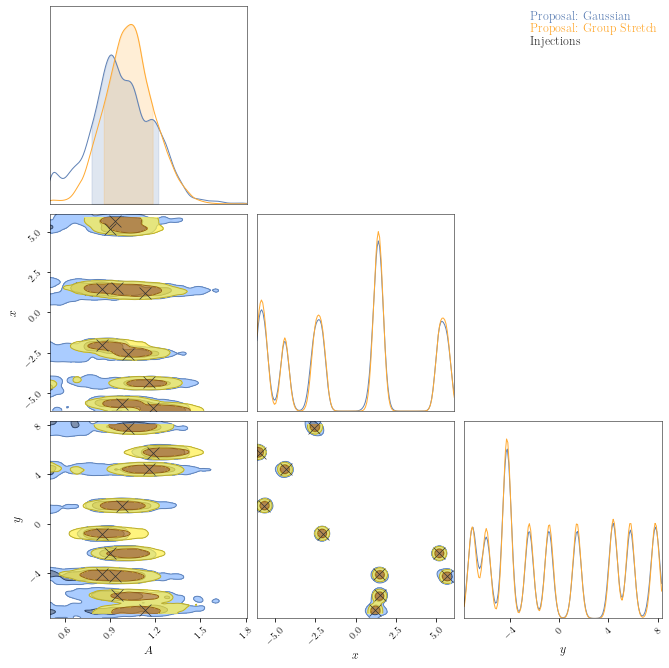

In [13]:

pulse_parameters = ["$A$", r"$x$", r"$y$"]
noise_parameters = ["$\sigma_\mathrm{noise}$"]

c = ChainConsumer()

c.add_chain(samples_gauss, parameters=pulse_parameters, name="Proposal: Gaussian", color=gauss_col)
c.add_chain(samples_group, parameters=pulse_parameters, name="Proposal: Group Stretch", color=group_col)
c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8, usetex=True, serif=True)

for ii in range(npulses):
    mrkrnm = "Injections" if ii==0 else ii*" " # just a trick to avoid multiple legend entries
    c.add_marker([gauss_inj_params[ii][0], gauss_inj_params[ii][1], gauss_inj_params[ii][2]], \
    parameters=pulse_parameters, marker_style="x", \
    marker_size=140, color="k", name=mrkrnm)

fig = c.plotter.plot(figsize=(10,10), legend=True);

Plot the posteriors for the noise parameters as well.

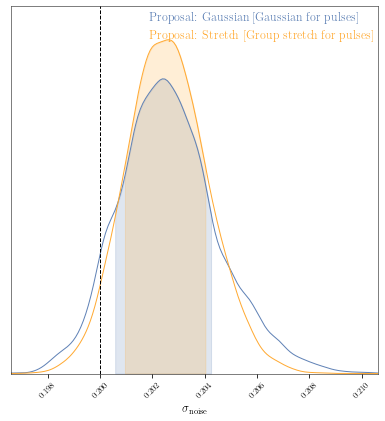

In [14]:
c = ChainConsumer()

samples_noise_group = get_clean_chain(ensemble_group.backend.get_chain(thin=1)["noise"], ndims["noise"])
samples_noise_gauss = get_clean_chain(ensemble_gauss.backend.get_chain(thin=1)["noise"], ndims["noise"])

c.add_chain(samples_noise_gauss, parameters=noise_parameters, name="Proposal: Gaussian [Gaussian for pulses]", color=gauss_col)
c.add_chain(samples_noise_group, parameters=noise_parameters, name="Proposal: Stretch [Group stretch for pulses]", color=group_col)

c.configure(bar_shade=True, tick_font_size=8, label_font_size=12, max_ticks=8, usetex=True, serif=True)
fig = c.plotter.plot(figsize=(6,6), legend=True, truth=sigma_noise[0]);


In [15]:
def get_clean_k_chains(backend, temp=0):
    """ A simple function to get the chains of model order k
    Args:
        backend: Eryn backend
    Returns:
        k_chain: the chains of the k model order
    """
    inds = backend.get_value("inds")  # Get the leaves out
    branches = {name: np.sum(inds[name], axis=-1, dtype=int) for name in inds}
    for (branch) in (branches):  # Get the total number of components/branches per temperature
        if branch == list(branches.keys())[0]:
            k_chain = branches[branch][:, temp].flatten()
        else:
            k_chain += branches[branch][:, temp].flatten()
    return k_chain

Plot the posterior on the model order, or in other words, the uncertainty on the model count.

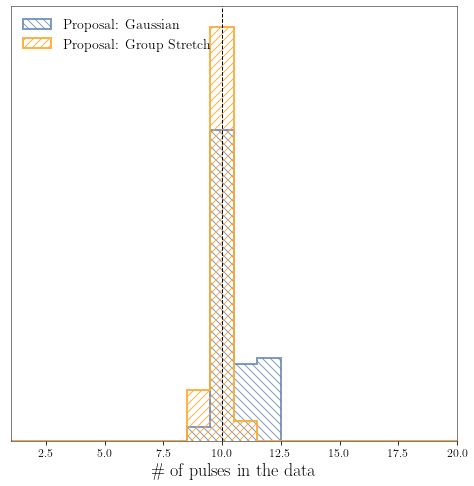

In [28]:
k_chain_group = get_clean_k_chains(ensemble_group.backend)
k_chain_gauss = get_clean_k_chains(ensemble_gauss.backend)

bns = (np.arange(1, nleaves_max["pulse"] + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch

fig = plt.figure(figsize=(8, 8))

plt.hist(
        k_chain_gauss-1,
        bins=bns,
        color=gauss_col,
        alpha=0.8,
        lw=2,
        histtype="step",
        density=True,
        hatch="\\\\\\",
        label="Proposal: Gaussian",
        )

plt.hist(
        k_chain_group-1,
        bins=bns,
        color=group_col,
        alpha=0.9,
        lw=2,
        histtype="step",
        density=True,
        hatch=r"///",
        label="Proposal: Group Stretch",
        )

plt.axvline(x=int(npulses), linestyle="--", lw=1, color="k")

plt.legend(loc="upper left", frameon=False)
plt.xticks(fontsize=12)
plt.yticks([])
plt.xlim(1, nleaves_max["pulse"])
plt.xlabel("$\#$ of pulses in the data")
plt.show()

## $fin$